<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN_GRU/CNN_GRU_EURUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [ ]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 6.06 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [ ]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [ ]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [ ]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [ ]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [ ]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 21 17:28:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [ ]:
# storing the file to be read as a string
in_str = 'EURUSD'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN_GRU'
# setting our window_length to be 30 days
window_len = 30

In [ ]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len, time_distributed=True)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [ ]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 14.9 MB/s 
     |████████████████████████████████| 170 kB 67.6 MB/s 
     |████████████████████████████████| 97 kB 8.8 MB/s 
     |████████████████████████████████| 133 kB 71.0 MB/s 
     |████████████████████████████████| 138 kB 69.3 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!pip install wandb -qq

In [ ]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [ ]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=config.activation), input_shape=(None, window_len, 1)))
    # layer 2
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    # layer 3
    model.add(TimeDistributed(Flatten()))
    # layer 4
    model.add(GRU(units=128, activation='tanh', return_sequences=False))
    # layer 5
    model.add(Dropout(0.1))
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [ ]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: oo7vuqb2
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN_GRU/sweeps/oo7vuqb2


In [ ]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: m2nwycex with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
32/32 [==============================] - 35s 34ms/step - loss: 0.1459 - mean_squared_error: 0.1459 - mean_absolute_error: 0.2865 - val_loss: 0.0321 - val_mean_squared_error: 0.0321 - val_mean_absolute_error: 0.1404
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0252 - mean_squared_error: 0.0252 - mean_absolute_error: 0.1325 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1316
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - mean_absolute_error: 0.1043 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1133
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0831 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.1026
Epoch 5/100
32/32 [==============================] - 0s 4ms/step - loss: 0.0073 - mean_squared_err

epoch,99
loss,0.00255
mean_squared_error,0.00255
mean_absolute_error,0.0396
val_loss,0.00911
val_mean_squared_error,0.00911
val_mean_absolute_error,0.07097
_runtime,62
_timestamp,1626888603
_step,99
best_val_loss,0.00909


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ge0xgwpr with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 4s 30ms/step - loss: 0.1382 - mean_squared_error: 0.1382 - mean_absolute_error: 0.1782 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0902
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0666 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0660
Epoch 3/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0505 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0873
Epoch 4/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0418 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0581
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0025 - mean_squared_erro

epoch,19
loss,0.00159
mean_squared_error,0.00159
mean_absolute_error,0.0309
val_loss,0.00562
val_mean_squared_error,0.00562
val_mean_absolute_error,0.05899
_runtime,12
_timestamp,1626888627
_step,19
best_val_loss,0.0045


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▂▃▂▃▂▁▁▂▁▂▁▁▂▁▁▁
val_loss,▇▃▆▂█▂▁▁▂▁▁▆▃▃▂▁▁▃▁▂
val_mean_squared_error,▇▃▆▂█▂▁▁▂▁▁▆▃▃▂▁▁▃▁▂
val_mean_absolute_error,▇▃▆▂█▂▁▁▃▁▁▇▃▃▂▂▂▃▁▂
_runtime,▁▁▁▃▃▃▃▅▅▅▅▆▆▆▆▆████
_timestamp,▁▁▁▃▃▃▃▅▅▅▅▆▆▆▆▆████
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: uk18h5ng with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 3s 57ms/step - loss: 1.7384 - mean_squared_error: 1.7384 - mean_absolute_error: 0.5870 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0872
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0514 - val_loss: 0.1844 - val_mean_squared_error: 0.1844 - val_mean_absolute_error: 0.3686
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0447 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1476 - val_loss: 0.1413 - val_mean_squared_error: 0.1413 - val_mean_absolute_error: 0.3212
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0275 - mean_squared_error: 0.0275 - mean_absolute_error: 0.1091 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0700
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0114 - mean_squared_erro

epoch,30
loss,0.00188
mean_squared_error,0.00188
mean_absolute_error,0.03397
val_loss,0.01077
val_mean_squared_error,0.01077
val_mean_absolute_error,0.08053
_runtime,10
_timestamp,1626888650
_step,30
best_val_loss,0.00642


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁█▆▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁█▆▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂█▇▁▁▁▂▁▂▃▁▂▁▂▁▁▁▁▁▁▁▂▁▂▂▁▂▂▁▂▁
_runtime,▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆████
_timestamp,▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆████
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: lyusvdug with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 4s 61ms/step - loss: 0.0509 - mean_squared_error: 0.0509 - mean_absolute_error: 0.1508 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0772
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0535 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0727
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0450 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0659
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0388 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0623
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0026 - mean_squared_error: 0.

epoch,49
loss,0.00093
mean_squared_error,0.00093
mean_absolute_error,0.02387
val_loss,0.00378
val_mean_squared_error,0.00378
val_mean_absolute_error,0.04927
_runtime,14
_timestamp,1626888675
_step,49
best_val_loss,0.00331


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▃▁▁▂▁▁▂▁▁▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: uh7ybh4c with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 3s 105ms/step - loss: 0.1929 - mean_squared_error: 0.1929 - mean_absolute_error: 0.3468 - val_loss: 0.2067 - val_mean_squared_error: 0.2067 - val_mean_absolute_error: 0.3721
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 0.1592 - mean_squared_error: 0.1592 - mean_absolute_error: 0.3026 - val_loss: 0.1504 - val_mean_squared_error: 0.1504 - val_mean_absolute_error: 0.3031
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 0.1144 - mean_squared_error: 0.1144 - mean_absolute_error: 0.2421 - val_loss: 0.1028 - val_mean_squared_error: 0.1028 - val_mean_absolute_error: 0.2390
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0820 - mean_squared_error: 0.0820 - mean_absolute_error: 0.1955 - val_loss: 0.0693 - val_mean_squared_error: 0.0693 - val_mean_absolute_error: 0.1920
Epoch 5/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0530 - mean_squared_error: 0.0530 - me

epoch,49
loss,0.00438
mean_squared_error,0.00438
mean_absolute_error,0.05135
val_loss,0.01216
val_mean_squared_error,0.01216
val_mean_absolute_error,0.08736
_runtime,12
_timestamp,1626888698
_step,49
best_val_loss,0.01216


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▅▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▅▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: v89ukvct with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 3s 28ms/step - loss: 0.0930 - mean_squared_error: 0.0930 - mean_absolute_error: 0.2191 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0888
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0554 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0773
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0423 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0766
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0441 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0803
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0032 - mean_squared_erro

epoch,99
loss,0.00139
mean_squared_error,0.00139
mean_absolute_error,0.02934
val_loss,0.00531
val_mean_squared_error,0.00531
val_mean_absolute_error,0.05757
_runtime,28
_timestamp,1626888738
_step,99
best_val_loss,0.00514


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▅▅▅▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: cusn07az with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 3s 63ms/step - loss: 0.0601 - mean_squared_error: 0.0601 - mean_absolute_error: 0.1676 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1307
Epoch 2/200
16/16 [==============================] - 0s 5ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0677 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0774
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0484 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0707
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0407 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0659
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0022 - mean_squared_erro

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,70
loss,0.00098
mean_squared_error,0.00098
mean_absolute_error,0.024
val_loss,0.00354
val_mean_squared_error,0.00354
val_mean_absolute_error,0.04892
_runtime,17
_timestamp,1626888785
_step,70
best_val_loss,0.00338


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: gei4oak2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 3s 54ms/step - loss: 1.3777 - mean_squared_error: 1.3777 - mean_absolute_error: 0.5509 - val_loss: 0.0144 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.0873
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0440 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0828
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0320 - mean_squared_error: 0.0320 - mean_absolute_error: 0.1020 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0741
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0727 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0798
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0089 - mean_squared_error: 0.

epoch,17
loss,0.00494
mean_squared_error,0.00494
mean_absolute_error,0.05454
val_loss,0.01187
val_mean_squared_error,0.01187
val_mean_absolute_error,0.08139
_runtime,10
_timestamp,1626888812
_step,17
best_val_loss,0.0074


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▃▃▂▂▂▂▂▂▁▂▁▁▁▂▁▁
val_loss,▃▂▂▂▃▃▃▁█▁▃▂▂▆▁▁▄▂
val_mean_squared_error,▃▂▂▂▃▃▃▁█▁▃▂▂▆▁▁▄▂
val_mean_absolute_error,▃▂▂▂▃▄▄▂█▁▃▂▂▇▁▁▄▂
_runtime,▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅███
_timestamp,▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅███
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: 6r6f7esi with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 3s 30ms/step - loss: 1.6860 - mean_squared_error: 1.6860 - mean_absolute_error: 0.7639 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1197
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0701 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0807
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0471 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0629
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0529 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0617
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_squared_error: 0.

epoch,49
loss,0.00084
mean_squared_error,0.00084
mean_absolute_error,0.02267
val_loss,0.00329
val_mean_squared_error,0.00329
val_mean_absolute_error,0.04712
_runtime,20
_timestamp,1626888842
_step,49
best_val_loss,0.00314


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▂▂▁▁▂▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: pic88jw8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 4s 56ms/step - loss: 1.8035 - mean_squared_error: 1.8035 - mean_absolute_error: 0.5903 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0811
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0448 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0722
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0491 - mean_squared_error: 0.0491 - mean_absolute_error: 0.1140 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0735
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0619 - val_loss: 0.0377 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1571
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0144 - mean_squared_erro

epoch,37
loss,0.0034
mean_squared_error,0.0034
mean_absolute_error,0.04133
val_loss,0.00648
val_mean_squared_error,0.00648
val_mean_absolute_error,0.06312
_runtime,12
_timestamp,1626888866
_step,37
best_val_loss,0.00498


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▄▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▂▂█▂▂▄▂▁▁▃▃▅▇▂▁▂▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▂▄▁▁
val_mean_squared_error,▃▂▂█▂▂▄▂▁▁▃▃▅▇▂▁▂▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▂▄▁▁
val_mean_absolute_error,▃▂▂█▂▃▅▂▂▂▃▃▅█▃▂▂▂▁▁▃▂▁▂▁▁▁▁▂▁▁▁▂▁▃▄▁▁
_runtime,▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
_timestamp,▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: klgxa583 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 3s 31ms/step - loss: 0.0404 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1090 - val_loss: 0.0358 - val_mean_squared_error: 0.0358 - val_mean_absolute_error: 0.1535
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0793 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0795
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0481 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1199
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0602 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0631
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0039 - mean_squared_erro

epoch,66
loss,0.0013
mean_squared_error,0.0013
mean_absolute_error,0.02705
val_loss,0.00372
val_mean_squared_error,0.00372
val_mean_absolute_error,0.04944
_runtime,22
_timestamp,1626888899
_step,66
best_val_loss,0.00333


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,██▆▄▅▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▅▂▂▂▁▃▂▁▁▁▂▁▁▁▁▁▁▃▁▁▁▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,█▃▂▅▂▂▂▁▃▂▁▁▁▂▁▁▁▁▁▁▃▁▁▁▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▆▂▃▂▂▄▃▁▂▁▂▁▂▁▁▂▁▃▁▁▁▁▁▂▁▂▁▁▁▁▃▁▁▁▂▁▁
_runtime,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 4fa29qb0 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 3s 112ms/step - loss: 0.7749 - mean_squared_error: 0.7749 - mean_absolute_error: 0.4704 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0770
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0481 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0751
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0592 - val_loss: 0.1840 - val_mean_squared_error: 0.1840 - val_mean_absolute_error: 0.3757
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0942 - mean_squared_error: 0.0942 - mean_absolute_error: 0.2242 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0754
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.004

epoch,57
loss,0.00328
mean_squared_error,0.00328
mean_absolute_error,0.04235
val_loss,0.00906
val_mean_squared_error,0.00906
val_mean_absolute_error,0.07234
_runtime,13
_timestamp,1626888924
_step,57
best_val_loss,0.00427


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▂▂▅▄▁▂▂▂▂▁▂▂▂▁▁▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁█▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁█▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▁▁█▃▂▂▁▁▃▃▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: r9seyvw0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 3s 111ms/step - loss: 0.0578 - mean_squared_error: 0.0578 - mean_absolute_error: 0.1591 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0841
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0519 - val_loss: 0.0260 - val_mean_squared_error: 0.0260 - val_mean_absolute_error: 0.1271
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0758 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1058
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0516 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0974
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - me

epoch,24
loss,0.00454
mean_squared_error,0.00454
mean_absolute_error,0.05126
val_loss,0.00911
val_mean_squared_error,0.00911
val_mean_absolute_error,0.06986
_runtime,9
_timestamp,1626888944
_step,24
best_val_loss,0.00733


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▄▂▃▂▂▃▁▂▂▂▂▁▂▂▂▂▁▂▂▁▂▁▂
mean_squared_error,█▂▄▂▃▂▂▃▁▂▂▂▂▁▂▂▂▂▁▂▂▁▂▁▂
mean_absolute_error,█▄▆▃▅▃▃▄▂▄▄▂▄▂▃▂▃▂▂▃▃▁▃▁▃
val_loss,▂▄▃▂▃▃▆▂█▂▄▁▂▄▁▆▁▂▂▂▂▁▁▂▁
val_mean_squared_error,▂▄▃▂▃▃▆▂█▂▄▁▂▄▁▆▁▂▂▂▂▁▁▂▁
val_mean_absolute_error,▂▅▃▃▃▃▇▂█▂▅▂▂▅▁▇▁▃▂▂▂▂▁▃▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁██████████████
_timestamp,▁▁▁▁▁▁▁▁▁▁▁██████████████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: sjbpcgrf with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 4s 118ms/step - loss: 0.1126 - mean_squared_error: 0.1126 - mean_absolute_error: 0.2360 - val_loss: 0.0964 - val_mean_squared_error: 0.0964 - val_mean_absolute_error: 0.2721
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0288 - mean_squared_error: 0.0288 - mean_absolute_error: 0.1318 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0933
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0837 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0817
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0501 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1135
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0047 - mean_squared_error: 0.0047

epoch,53
loss,0.00095
mean_squared_error,0.00095
mean_absolute_error,0.02381
val_loss,0.00506
val_mean_squared_error,0.00506
val_mean_absolute_error,0.05632
_runtime,14
_timestamp,1626888972
_step,53
best_val_loss,0.00453


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█████
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ey92lfcg with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 4s 56ms/step - loss: 0.3090 - mean_squared_error: 0.3090 - mean_absolute_error: 0.2684 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0865
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0513 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1192
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0655 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0661
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0440 - val_loss: 0.0888 - val_mean_squared_error: 0.0888 - val_mean_absolute_error: 0.2537
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0166 - mean_squared_erro

epoch,49
loss,0.00186
mean_squared_error,0.00186
mean_absolute_error,0.03311
val_loss,0.00464
val_mean_squared_error,0.00464
val_mean_absolute_error,0.0548
_runtime,16
_timestamp,1626889000
_step,49
best_val_loss,0.00398


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▃▂▂▂▃▃▁▁▁▂▁▁▃▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁
val_loss,▂▃▁█▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_squared_error,▂▃▁█▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,▂▃▁█▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▂▁▁▂▁▁▂▁▂▁▂▂▁▁▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 17e63e83 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 4s 34ms/step - loss: 0.1491 - mean_squared_error: 0.1491 - mean_absolute_error: 0.1865 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0789
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0545 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0785
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0693 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0857
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0574 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0753
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.

epoch,35
loss,0.00222
mean_squared_error,0.00222
mean_absolute_error,0.03258
val_loss,0.00424
val_mean_squared_error,0.00424
val_mean_absolute_error,0.05382
_runtime,19
_timestamp,1626889041
_step,35
best_val_loss,0.00379


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▂▂▃▃▂▂▂▂▂▂▁▂▁▁▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▂
val_loss,▄▃▄▃▂▂▃▂▁▁█▁▁▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁
val_mean_squared_error,▄▃▄▃▂▂▃▂▁▁█▁▁▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁
val_mean_absolute_error,▄▄▅▄▂▂▃▂▂▂█▁▁▂▁▂▂▂▂▂▁▁▁▁▁▁▂▂▁▁▁▂▂▁▂▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: t9bzuqff with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 4s 120ms/step - loss: 2.5530 - mean_squared_error: 2.5530 - mean_absolute_error: 0.9044 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1431
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0965 - val_loss: 0.0428 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1707
Epoch 3/200
8/8 [==============================] - 0s 11ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.1043 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0735
Epoch 4/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0432 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0747
Epoch 5/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0102 - mean_squared_error: 0.0

epoch,57
loss,0.00572
mean_squared_error,0.00572
mean_absolute_error,0.05555
val_loss,0.00778
val_mean_squared_error,0.00778
val_mean_absolute_error,0.06959
_runtime,15
_timestamp,1626889069
_step,57
best_val_loss,0.00331


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▃▂▁
val_loss,▃▄▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂█▂▁▁
val_mean_squared_error,▃▄▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂█▂▁▁
val_mean_absolute_error,▄▄▂▂▁▁▁▃▃▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂█▃▂▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: dlxlfyfu with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 4s 61ms/step - loss: 0.8452 - mean_squared_error: 0.8452 - mean_absolute_error: 0.3923 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0771
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0557 - val_loss: 0.1447 - val_mean_squared_error: 0.1447 - val_mean_absolute_error: 0.3326
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0600 - mean_squared_error: 0.0600 - mean_absolute_error: 0.1758 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0697
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0263 - mean_squared_error: 0.0263 - mean_absolute_error: 0.0847 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0730
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0079 - mean_squared_erro

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,78
loss,0.00175
mean_squared_error,0.00175
mean_absolute_error,0.03011
val_loss,0.00409
val_mean_squared_error,0.00409
val_mean_absolute_error,0.05057
_runtime,19
_timestamp,1626889101
_step,78
best_val_loss,0.00324


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▂▂▂▂▂▂▂▁▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂█▄▃▁▂▁▃▂▄▂▂▁▁▃▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▂█▄▃▁▂▁▃▂▄▂▂▁▁▃▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▂█▅▄▂▂▂▃▂▄▂▂▂▁▄▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 50jh1yy7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 4s 33ms/step - loss: 1.2402 - mean_squared_error: 1.2402 - mean_absolute_error: 0.6671 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1257
Epoch 2/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0579 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0682
Epoch 3/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0416 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0633
Epoch 4/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0349 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0541
Epoch 5/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_squared_erro

epoch,40
loss,0.00102
mean_squared_error,0.00102
mean_absolute_error,0.02467
val_loss,0.00323
val_mean_squared_error,0.00323
val_mean_absolute_error,0.04669
_runtime,19
_timestamp,1626889137
_step,40
best_val_loss,0.00313


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▂▂▂▂▁▁▂▂▁▂▁▁▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▂▁
_runtime,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: 545idb3u with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 4s 172ms/step - loss: 0.3898 - mean_squared_error: 0.3898 - mean_absolute_error: 0.3521 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0786
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0467 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0861
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0695 - val_loss: 0.0489 - val_mean_squared_error: 0.0489 - val_mean_absolute_error: 0.1821
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0719 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0836
Epoch 5/200
8/8 [==============================] - 0s 11ms/step - loss: 0.0041 - mean_squared_error: 0.004

epoch,27
loss,0.00223
mean_squared_error,0.00223
mean_absolute_error,0.0372
val_loss,0.00511
val_mean_squared_error,0.00511
val_mean_absolute_error,0.05628
_runtime,12
_timestamp,1626889162
_step,27
best_val_loss,0.00487


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▄▂▂▂▁▁▂▃▂▁▁▂▃▁▁▁▂▂▂▁▁▂▁▂▂▁
val_loss,▂▂█▂▂▁▁▂▅▃▂▁▂▅▂▁▁▁▁▁▁▁▁▂▃▂▂▁
val_mean_squared_error,▂▂█▂▂▁▁▂▅▃▂▁▂▅▂▁▁▁▁▁▁▁▁▂▃▂▂▁
val_mean_absolute_error,▂▃█▃▂▂▂▂▆▃▂▁▂▅▂▁▁▁▁▁▁▁▁▂▄▃▂▁
_runtime,▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆████
_timestamp,▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆████
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: ltrm9ygg with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 3s 62ms/step - loss: 0.0702 - mean_squared_error: 0.0702 - mean_absolute_error: 0.1745 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0810
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0628 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0770
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0499 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0721
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0426 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0641
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_squared_erro

epoch,76
loss,0.00082
mean_squared_error,0.00082
mean_absolute_error,0.02221
val_loss,0.00379
val_mean_squared_error,0.00379
val_mean_absolute_error,0.04915
_runtime,20
_timestamp,1626889194
_step,76
best_val_loss,0.00324


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▂▂▂▁▁▂▁▁▁▁▂▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▂▂▂▂▂▂▁▁▂▁▁▁▁▂▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▄▃▃▃▂▂▂▂▂▃▂▂▂▂▂▁▁▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 2ibhz575 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 3s 28ms/step - loss: 0.0486 - mean_squared_error: 0.0486 - mean_absolute_error: 0.1216 - val_loss: 0.0266 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1291
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0733 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0869
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0740 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0751
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0605 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0639
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_squared_erro

epoch,74
loss,0.00124
mean_squared_error,0.00124
mean_absolute_error,0.02739
val_loss,0.00448
val_mean_squared_error,0.00448
val_mean_absolute_error,0.05317
_runtime,24
_timestamp,1626889235
_step,74
best_val_loss,0.00333


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▄▄▂▁▂▁▁▂▁▂▁▁▁▁▁▂▁▂▃▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▄▄▂▁▂▁▁▂▁▂▁▁▁▁▁▂▁▂▃▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▂▃▅▅▂▂▂▁▂▂▂▃▁▂▂▂▁▂▂▂▃▁▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: pibbe8yl with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 4s 58ms/step - loss: 0.1771 - mean_squared_error: 0.1771 - mean_absolute_error: 0.3274 - val_loss: 0.1422 - val_mean_squared_error: 0.1422 - val_mean_absolute_error: 0.2936
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 0.1009 - mean_squared_error: 0.1009 - mean_absolute_error: 0.2247 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.1819
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0434 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1405 - val_loss: 0.0341 - val_mean_squared_error: 0.0341 - val_mean_absolute_error: 0.1380
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0247 - mean_squared_error: 0.0247 - mean_absolute_error: 0.1162 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1287
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0224 - mean_squared_error: 0.

epoch,49
loss,0.00319
mean_squared_error,0.00319
mean_absolute_error,0.04394
val_loss,0.0111
val_mean_squared_error,0.0111
val_mean_absolute_error,0.07762
_runtime,17
_timestamp,1626889266
_step,49
best_val_loss,0.01096


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: khm4l3o0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 3s 56ms/step - loss: 0.0467 - mean_squared_error: 0.0467 - mean_absolute_error: 0.1130 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0766
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0620 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0744
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0499 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0762
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0443 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1062
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_squared_error: 0.

epoch,49
loss,0.00145
mean_squared_error,0.00145
mean_absolute_error,0.02967
val_loss,0.00403
val_mean_squared_error,0.00403
val_mean_absolute_error,0.05177
_runtime,15
_timestamp,1626889297
_step,49
best_val_loss,0.0037


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▂▂▃▂▂▃▂▂▂▂▁▁▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▃▂▂▃▂▂▂▂▁▁▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▆▄▄▆▅▄▅▄▃▃▄▂▂▄▃▂▂▂▃▂▂▃▂▂▂▂▂▂▂▁▂▂▁▂▂▂▂▁
val_loss,▃▃▄█▃▃▄▃▂▇▂▃▃▁▂▂▂▂▁▁▁▁▃█▃▂▁▂▂▁▁▁▂▁▂▂▁▂▁▁
val_mean_squared_error,▃▃▄█▃▃▄▃▂▇▂▃▃▁▂▂▂▂▁▁▁▁▃█▃▂▁▂▂▁▁▁▂▁▂▂▁▂▁▁
val_mean_absolute_error,▄▄▄█▄▃▄▃▂▇▂▃▂▂▃▂▂▂▂▁▁▁▃█▃▃▁▂▂▁▁▁▂▁▂▂▁▃▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 7aik9z5e with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 4s 90ms/step - loss: 2.2979 - mean_squared_error: 2.2979 - mean_absolute_error: 0.6405 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0786
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0482 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0784
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0607 - mean_squared_error: 0.0607 - mean_absolute_error: 0.1411 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1067
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0795 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1200
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0129 - mean_squared_erro

epoch,30
loss,0.00325
mean_squared_error,0.00325
mean_absolute_error,0.042
val_loss,0.02626
val_mean_squared_error,0.02626
val_mean_absolute_error,0.13454
_runtime,14
_timestamp,1626889327
_step,30
best_val_loss,0.00591


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂▄▄▄▂█▂▇▁▂▆▁▂▁▁▁▁▁▂▁▁▁▁▁▂▃▃▂▄▅
val_mean_squared_error,▂▂▄▄▄▂█▂▇▁▂▆▁▂▁▁▁▁▁▂▁▁▁▁▁▂▃▃▂▄▅
val_mean_absolute_error,▂▂▄▅▅▂█▂█▁▃▇▂▂▁▂▁▁▂▃▁▁▁▁▂▃▄▃▂▅▆
_runtime,▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆█████
_timestamp,▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆█████
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: qvstjtse with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 3s 29ms/step - loss: 0.1694 - mean_squared_error: 0.1694 - mean_absolute_error: 0.3146 - val_loss: 0.0669 - val_mean_squared_error: 0.0669 - val_mean_absolute_error: 0.1881
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1413 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1334
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - mean_absolute_error: 0.1167 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1293
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.1094 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1212
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0145 - mean_squared_erro

epoch,99
loss,0.00286
mean_squared_error,0.00286
mean_absolute_error,0.04174
val_loss,0.01038
val_mean_squared_error,0.01038
val_mean_absolute_error,0.07493
_runtime,30
_timestamp,1626889371
_step,99
best_val_loss,0.01038


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: bfc1ik2o with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 3s 30ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - mean_absolute_error: 0.0995 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0803
Epoch 2/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0451 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0708
Epoch 3/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0391 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0592
Epoch 4/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0340 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0564
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0020 - mean_squared_erro

epoch,45
loss,0.00096
mean_squared_error,0.00096
mean_absolute_error,0.02383
val_loss,0.00316
val_mean_squared_error,0.00316
val_mean_absolute_error,0.04623
_runtime,21
_timestamp,1626889424
_step,45
best_val_loss,0.00314


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▃▂▂▁▂▂▂▁▂▂▁▂▂▂▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▃▂▂▂▁▂▁▁▂▂▁▁▂▁▂▁▁▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▃▃▂▂▂▁▂▁▁▂▂▁▁▂▁▂▁▁▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▃▁▁▁▃▃▁▂▂▁▁▁▁▂▂▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: slyjhdui with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 4s 34ms/step - loss: 0.2104 - mean_squared_error: 0.2104 - mean_absolute_error: 0.2160 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0677
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0561 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0701
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0621 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0850
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0616 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0602
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.

epoch,18
loss,0.00114
mean_squared_error,0.00114
mean_absolute_error,0.026
val_loss,0.00468
val_mean_squared_error,0.00468
val_mean_absolute_error,0.05483
_runtime,15
_timestamp,1626889456
_step,18
best_val_loss,0.00437


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▃▂▂▃▁▂▃▁▁▂▁▂▁▁
val_loss,▂▂▃▂▂█▁▂▁▁▁▂▂▁▂▁▁▁▁
val_mean_squared_error,▂▂▃▂▂█▁▂▁▁▁▂▂▁▂▁▁▁▁
val_mean_absolute_error,▂▂▃▂▂█▁▂▁▁▁▂▂▁▃▁▁▁▁
_runtime,▁▁▂▂▂▂▄▄▄▅▅▅▅▇▇▇▇██
_timestamp,▁▁▂▂▂▂▄▄▄▅▅▅▅▇▇▇▇██
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: fapc5c73 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 3s 32ms/step - loss: 0.0406 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1360 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0818
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0473 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0775
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0373 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0663
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0343 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0621
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0017 - mean_squared_erro

epoch,55
loss,0.00085
mean_squared_error,0.00085
mean_absolute_error,0.02271
val_loss,0.00342
val_mean_squared_error,0.00342
val_mean_absolute_error,0.04761
_runtime,23
_timestamp,1626889493
_step,55
best_val_loss,0.00326


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,█▇▅▃▃▃▂▄▃▂▂▃▂▁▂▁▁▂▁▃▁▁▁▁▁▂▁▂▁▂▁▂▁▁▁▁▁▂▃▁
val_mean_squared_error,█▇▅▃▃▃▂▄▃▂▂▃▂▁▂▁▁▂▁▃▁▁▁▁▁▂▁▂▁▂▁▂▁▁▁▁▁▂▃▁
val_mean_absolute_error,█▇▅▄▃▃▃▄▃▂▃▃▂▂▃▂▁▃▁▃▁▂▁▁▁▃▁▂▁▃▁▂▁▁▁▁▂▃▃▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2qgwiudu with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 115ms/step - loss: 0.2752 - mean_squared_error: 0.2752 - mean_absolute_error: 0.3007 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0953
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0761 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1095
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - mean_absolute_error: 0.0980 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0747
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0457 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0801
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030 

epoch,49
loss,0.00126
mean_squared_error,0.00126
mean_absolute_error,0.02787
val_loss,0.00427
val_mean_squared_error,0.00427
val_mean_absolute_error,0.05378
_runtime,15
_timestamp,1626889528
_step,49
best_val_loss,0.00427


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▂▃▂▂▁▂▁▁▂▁▁▁▂▁▁▁▁▂▁▁▁▂▁▁▁▁▂▁▂▁▁▁▂▁▁▁▁
val_loss,▅▇▃▄▂▄▂▃▂▁▂█▂▁▂▆▁▁▁▁▁▁▁▂▄▁▁▁▂▁▁▁▁▁▁▄▁▁▁▁
val_mean_squared_error,▅▇▃▄▂▄▂▃▂▁▂█▂▁▂▆▁▁▁▁▁▁▁▂▄▁▁▁▂▁▁▁▁▁▁▄▁▁▁▁
val_mean_absolute_error,▅▇▃▄▂▃▂▃▂▂▂█▂▁▂▆▁▁▂▁▁▁▁▂▄▁▁▁▂▁▁▂▁▁▁▄▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: qb7typj6 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 3s 119ms/step - loss: 7.3397 - mean_squared_error: 7.3397 - mean_absolute_error: 1.6953 - val_loss: 0.0359 - val_mean_squared_error: 0.0359 - val_mean_absolute_error: 0.1678
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0275 - mean_squared_error: 0.0275 - mean_absolute_error: 0.1342 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1171
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0864 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1230
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0715 - mean_squared_error: 0.0715 - mean_absolute_error: 0.2058 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1122
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0243 - mean_squared_error: 0.024

epoch,45
loss,0.00484
mean_squared_error,0.00484
mean_absolute_error,0.05382
val_loss,0.00929
val_mean_squared_error,0.00929
val_mean_absolute_error,0.07268
_runtime,14
_timestamp,1626889557
_step,45
best_val_loss,0.00572


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂▂▂██▂▁▄▁▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂
val_mean_squared_error,▂▂▂▂██▂▁▄▁▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂
val_mean_absolute_error,▄▂▃▂██▃▂▅▁▂▁▁▃▂▁▁▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▂▁▂
_runtime,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆████
_timestamp,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: 2k4pm7yb with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 3s 118ms/step - loss: 5.8018 - mean_squared_error: 5.8018 - mean_absolute_error: 1.4849 - val_loss: 0.0297 - val_mean_squared_error: 0.0297 - val_mean_absolute_error: 0.1436
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - mean_absolute_error: 0.1158 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1072
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0795 - val_loss: 0.2746 - val_mean_squared_error: 0.2746 - val_mean_absolute_error: 0.4735
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.1466 - mean_squared_error: 0.1466 - mean_absolute_error: 0.2929 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1149
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0543 - mean_squared_error: 0.0543

epoch,20
loss,0.00808
mean_squared_error,0.00808
mean_absolute_error,0.0657
val_loss,0.01423
val_mean_squared_error,0.01423
val_mean_absolute_error,0.08826
_runtime,11
_timestamp,1626889589
_step,20
best_val_loss,0.01005


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▁█▁▂▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,▂▁█▁▂▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,▂▂█▂▂▃▄▂▁▃▁▁▁▁▂▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁█████████████
_timestamp,▁▁▁▁▁▁▁▁█████████████
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: uk1bq06n with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 3s 125ms/step - loss: 0.2369 - mean_squared_error: 0.2369 - mean_absolute_error: 0.2973 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0779
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0466 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0767
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0686 - val_loss: 0.1205 - val_mean_squared_error: 0.1205 - val_mean_absolute_error: 0.2901
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0468 - mean_squared_error: 0.0468 - mean_absolute_error: 0.1613 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0756
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.004

epoch,24
loss,0.00359
mean_squared_error,0.00359
mean_absolute_error,0.04615
val_loss,0.00897
val_mean_squared_error,0.00897
val_mean_absolute_error,0.0757
_runtime,12
_timestamp,1626889617
_step,24
best_val_loss,0.00597


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▂▂▁▂▁▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▂▁▂▁▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▄▅▂▅▃▃▂▄▂▃▁▃▁▃▁▂▂▁▂▂▂▂▁
val_loss,▁▁█▁▂▁▂▁▅▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁█▁▂▁▂▁▅▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▂█▁▂▂▃▁▆▁▄▂▂▁▁▁▂▂▁▂▁▂▂▁▁
_runtime,▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅█████████
_timestamp,▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅█████████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 5g1ae1uj with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 4s 30ms/step - loss: 0.1278 - mean_squared_error: 0.1278 - mean_absolute_error: 0.2602 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1156
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0810 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0990
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0581 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0921
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0542 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0877
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0041 - mean_squared_error: 0.

epoch,49
loss,0.00289
mean_squared_error,0.00289
mean_absolute_error,0.0415
val_loss,0.009
val_mean_squared_error,0.009
val_mean_absolute_error,0.07145
_runtime,22
_timestamp,1626889656
_step,49
best_val_loss,0.009


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 6u4kni72 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 3s 59ms/step - loss: 0.0567 - mean_squared_error: 0.0567 - mean_absolute_error: 0.1589 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0806
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0635 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0806
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0487 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0682
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0412 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0683
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.

epoch,49
loss,0.00089
mean_squared_error,0.00089
mean_absolute_error,0.02283
val_loss,0.00337
val_mean_squared_error,0.00337
val_mean_absolute_error,0.04738
_runtime,18
_timestamp,1626889689
_step,49
best_val_loss,0.00329


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_loss,█▇▆▆▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▂▂▁▁▁
val_mean_squared_error,█▇▆▆▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▂▂▁▁▁
val_mean_absolute_error,██▅▅▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▂▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: kr69oq6f with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 3s 60ms/step - loss: 0.1040 - mean_squared_error: 0.1040 - mean_absolute_error: 0.1961 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1020
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0213 - mean_squared_error: 0.0213 - mean_absolute_error: 0.0978 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0809
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0716 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0803
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0781 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0777
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0083 - mean_squared_error: 0.

epoch,49
loss,0.0019
mean_squared_error,0.0019
mean_absolute_error,0.03208
val_loss,0.0059
val_mean_squared_error,0.0059
val_mean_absolute_error,0.0618
_runtime,18
_timestamp,1626889724
_step,49
best_val_loss,0.00351


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▆▅▄▄▃▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,▅▃▃▂▄▃▂▂▂▂█▂▂▂▂▂▁▁▃▁▁▁▁▂▂▁▁▂▁▁▁▃▁▁▁▁▂▂▁▂
val_mean_squared_error,▅▃▃▂▄▃▂▂▂▂█▂▂▂▂▂▁▁▃▁▁▁▁▂▂▁▁▂▁▁▁▃▁▁▁▁▂▂▁▂
val_mean_absolute_error,▆▄▄▃▅▄▃▂▂▂█▂▂▂▂▃▂▁▃▂▁▁▁▂▂▁▂▂▂▁▁▄▁▁▁▁▂▂▁▂
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 0frzx2yd with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 4s 59ms/step - loss: 0.0798 - mean_squared_error: 0.0798 - mean_absolute_error: 0.1929 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0998
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0848 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0855
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0513 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0634
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0385 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.1074
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0151 - mean_squared_error: 0

epoch,49
loss,0.0011
mean_squared_error,0.0011
mean_absolute_error,0.02548
val_loss,0.00392
val_mean_squared_error,0.00392
val_mean_absolute_error,0.05091
_runtime,19
_timestamp,1626889759
_step,49
best_val_loss,0.00338


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,▇▅▃█▂▂▂▅▂▂▂▇▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇▅▃█▂▂▂▅▂▂▂▇▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇▅▃█▂▂▂▅▂▂▃▇▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: eanh3hem with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
16/16 [==============================] - 3s 60ms/step - loss: 0.0933 - mean_squared_error: 0.0933 - mean_absolute_error: 0.2197 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1542
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.1045 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0849
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0549 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0803
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0430 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0771
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0031 - mean_squared_erro

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,175
loss,0.00144
mean_squared_error,0.00144
mean_absolute_error,0.02976
val_loss,0.00539
val_mean_squared_error,0.00539
val_mean_absolute_error,0.0571
_runtime,36
_timestamp,1626889813
_step,175
best_val_loss,0.0052


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,███▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_mean_squared_error,███▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ipzz8jsu with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 62ms/step - loss: 0.0726 - mean_squared_error: 0.0726 - mean_absolute_error: 0.1845 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1216
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0836 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0812
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0497 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0871
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0467 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0831
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_squared_erro

epoch,99
loss,0.00084
mean_squared_error,0.00084
mean_absolute_error,0.02237
val_loss,0.00321
val_mean_squared_error,0.00321
val_mean_absolute_error,0.04614
_runtime,27
_timestamp,1626889863
_step,99
best_val_loss,0.00321


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: h6xm9b3k with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 3s 30ms/step - loss: 0.0797 - mean_squared_error: 0.0797 - mean_absolute_error: 0.2066 - val_loss: 0.0196 - val_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.1200
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0863 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0987
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0636 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0896
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0512 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0852
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0040 - mean_squared_error: 0.

epoch,49
loss,0.00272
mean_squared_error,0.00272
mean_absolute_error,0.04045
val_loss,0.00946
val_mean_squared_error,0.00946
val_mean_absolute_error,0.07189
_runtime,21
_timestamp,1626889902
_step,49
best_val_loss,0.00946


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: u1bcv7s5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 4s 32ms/step - loss: 0.0343 - mean_squared_error: 0.0343 - mean_absolute_error: 0.1091 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0750
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0421 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0672
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0396 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0642
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0308 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0742
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0026 - mean_squared_err

epoch,70
loss,0.00084
mean_squared_error,0.00084
mean_absolute_error,0.02188
val_loss,0.00367
val_mean_squared_error,0.00367
val_mean_absolute_error,0.04904
_runtime,31
_timestamp,1626889958
_step,70
best_val_loss,0.00321


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▃▂▂▂▃▂▁▁▂▂▁▁▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▃▄█▂▂▅▂▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▃▁▁
val_mean_squared_error,▅▃▄█▂▂▅▂▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▃▁▁
val_mean_absolute_error,▄▄▄█▂▂▅▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▃▂▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 9kvytyxq with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 3s 60ms/step - loss: 0.1700 - mean_squared_error: 0.1700 - mean_absolute_error: 0.3151 - val_loss: 0.0623 - val_mean_squared_error: 0.0623 - val_mean_absolute_error: 0.1825
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0300 - mean_squared_error: 0.0300 - mean_absolute_error: 0.1193 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1125
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0874 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1130
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0843 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.1025
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0072 - mean_squared_error: 0.

epoch,49
loss,0.00353
mean_squared_error,0.00353
mean_absolute_error,0.04618
val_loss,0.01054
val_mean_squared_error,0.01054
val_mean_absolute_error,0.07679
_runtime,19
_timestamp,1626889991
_step,49
best_val_loss,0.01054


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2is4dfhp with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 3s 56ms/step - loss: 0.1718 - mean_squared_error: 0.1718 - mean_absolute_error: 0.3205 - val_loss: 0.1171 - val_mean_squared_error: 0.1171 - val_mean_absolute_error: 0.2623
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0829 - mean_squared_error: 0.0829 - mean_absolute_error: 0.2059 - val_loss: 0.0445 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1526
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0325 - mean_squared_error: 0.0325 - mean_absolute_error: 0.1229 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1231
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.1029 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1213
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0145 - mean_squared_erro

epoch,81
loss,0.00312
mean_squared_error,0.00312
mean_absolute_error,0.04337
val_loss,0.0116
val_mean_squared_error,0.0116
val_mean_absolute_error,0.07904
_runtime,22
_timestamp,1626890028
_step,81
best_val_loss,0.01152


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 34c03cnd with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 4s 65ms/step - loss: 0.0310 - mean_squared_error: 0.0310 - mean_absolute_error: 0.0948 - val_loss: 0.0432 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1738
Epoch 2/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0740 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0751
Epoch 3/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0584 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0654
Epoch 4/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0350 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0736
Epoch 5/200
16/16 [==============================] - 0s 13ms/step - loss: 0.0019 - mean_squared_e

epoch,23
loss,0.00118
mean_squared_error,0.00118
mean_absolute_error,0.02639
val_loss,0.00499
val_mean_squared_error,0.00499
val_mean_absolute_error,0.05503
_runtime,15
_timestamp,1626890066
_step,23
best_val_loss,0.00426


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▄▇▂▁▁▂▁▂▂▂▂▁▁▂▁▂▂▁▁▁▂▁▁
mean_squared_error,█▄▇▂▁▁▂▁▂▂▂▂▁▁▂▁▂▂▁▁▁▂▁▁
mean_absolute_error,▇▆█▃▂▂▃▂▃▃▃▂▂▁▃▁▃▃▂▂▁▃▁▁
val_loss,█▂▂▂▂▁▁▁▂▂▃▁▁▁▁▂▃▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▁▁▁▂▂▃▁▁▁▁▂▃▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▁▁▁▂▂▃▁▁▁▁▂▃▁▁▁▂▁▁▁
_runtime,▁▁▁▁▁▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆███
_timestamp,▁▁▁▁▁▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆███
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: qp71h5q8 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 3s 32ms/step - loss: 3.2962 - mean_squared_error: 3.2962 - mean_absolute_error: 0.8350 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1281
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0501 - mean_squared_error: 0.0501 - mean_absolute_error: 0.1796 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0942
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - mean_absolute_error: 0.1194 - val_loss: 0.0488 - val_mean_squared_error: 0.0488 - val_mean_absolute_error: 0.1874
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - mean_absolute_error: 0.0995 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0992
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0093 - mean_squared_erro

epoch,23
loss,0.00409
mean_squared_error,0.00409
mean_absolute_error,0.0461
val_loss,0.00554
val_mean_squared_error,0.00554
val_mean_absolute_error,0.06067
_runtime,16
_timestamp,1626890102
_step,23
best_val_loss,0.00478


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▃█▂▂▂▂▁▂▃▁▃▃▁▁▃▁▁▁▁▁▂▂▁
val_mean_squared_error,▄▃█▂▂▂▂▁▂▃▁▃▃▁▁▃▁▁▁▁▁▂▂▁
val_mean_absolute_error,▅▃█▃▂▂▂▁▂▃▁▃▃▁▁▃▂▂▁▂▂▂▃▁
_runtime,▁▁▁▁▂▂▂▄▄▄▄▅▅▅▅▅▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▄▄▄▄▅▅▅▅▅▇▇▇▇████
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: w623xfbs with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 4s 58ms/step - loss: 0.1410 - mean_squared_error: 0.1410 - mean_absolute_error: 0.2190 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1070
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0248 - mean_squared_error: 0.0248 - mean_absolute_error: 0.1106 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0722
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - mean_absolute_error: 0.0807 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0855
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0781 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1056
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0079 - mean_squared_erro

epoch,79
loss,0.0019
mean_squared_error,0.0019
mean_absolute_error,0.03179
val_loss,0.00341
val_mean_squared_error,0.00341
val_mean_absolute_error,0.04819
_runtime,22
_timestamp,1626890139
_step,79
best_val_loss,0.0033


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▄▃▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▄▃▃▂▂▂█▂▂▁▇▁▁▁▂▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,▆▄▃▃▂▂▂█▂▂▁▇▁▁▁▂▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,▇▅▄▃▂▂▃█▂▂▂▇▂▂▁▃▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5lm8ovqt with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 4s 31ms/step - loss: 0.0414 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1307 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0764
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0476 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0666
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0386 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0625
Epoch 4/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0329 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0612
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.

epoch,49
loss,0.00111
mean_squared_error,0.00111
mean_absolute_error,0.0256
val_loss,0.00376
val_mean_squared_error,0.00376
val_mean_absolute_error,0.04981
_runtime,23
_timestamp,1626890185
_step,49
best_val_loss,0.00323


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_loss,█▆▆▅▄▃▃▃▄▃▃▂▃▂▂▂▂▁▂▂▁▁▁▂▂▂▁▁▁▁▁▄▂▂▁▁▂▁▂▂
val_mean_squared_error,█▆▆▅▄▃▃▃▄▃▃▂▃▂▂▂▂▁▂▂▁▁▁▂▂▂▁▁▁▁▁▄▂▂▁▁▂▁▂▂
val_mean_absolute_error,█▆▅▄▃▃▃▃▃▃▃▂▃▃▂▂▂▁▂▂▁▁▁▂▂▂▂▂▁▂▁▄▂▂▁▁▂▁▂▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: mx0m0lr8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 4s 125ms/step - loss: 0.1082 - mean_squared_error: 0.1082 - mean_absolute_error: 0.2224 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.1043
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0513 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0814
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0443 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0752
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0427 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0733
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0027 - mean_squared_error: 0.

epoch,57
loss,0.00132
mean_squared_error,0.00132
mean_absolute_error,0.0281
val_loss,0.0068
val_mean_squared_error,0.0068
val_mean_absolute_error,0.0636
_runtime,18
_timestamp,1626890225
_step,57
best_val_loss,0.00419


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▂▂▁▁▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▂▁▁
val_loss,█▅▄▃▃▂▂▂▂▄▃▂▁▂▂▃▂▂▁▃▂▂▁▁▂▂▁▁▁▃▁▂▁▁▂▂▁▂▁▂
val_mean_squared_error,█▅▄▃▃▂▂▂▂▄▃▂▁▂▂▃▂▂▁▃▂▂▁▁▂▂▁▁▁▃▁▂▁▁▂▂▁▂▁▂
val_mean_absolute_error,█▅▄▃▃▂▂▂▂▄▃▂▂▃▂▃▂▃▁▃▂▂▁▁▂▂▁▁▁▄▁▂▁▁▂▂▁▂▁▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ynku1ioi with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 4s 118ms/step - loss: 0.0827 - mean_squared_error: 0.0827 - mean_absolute_error: 0.1800 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0940
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0458 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0797
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0444 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0701
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0468 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0678
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041 

epoch,49
loss,0.00126
mean_squared_error,0.00126
mean_absolute_error,0.02797
val_loss,0.00383
val_mean_squared_error,0.00383
val_mean_absolute_error,0.04934
_runtime,17
_timestamp,1626890257
_step,49
best_val_loss,0.00383


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▃▃▄▂▂▂▃▁▂▃▂▁▁▁▂▃▂▁▂▃▁▁▁▁▂▂▁▁▂▂▁▁▂▁
val_loss,█▆▄▄▃▃▂▃▂▂▂▄▃▃▄▄▂▂▃▁▂▃▂▁▁▁▂▁▁▂▃▂▂▃▂▂▁▁▁▁
val_mean_squared_error,█▆▄▄▃▃▂▃▂▂▂▄▃▃▄▄▂▂▃▁▂▃▂▁▁▁▂▁▁▂▃▂▂▃▂▂▁▁▁▁
val_mean_absolute_error,█▆▄▄▄▄▃▄▃▂▂▄▄▃▄▄▂▃▃▂▃▄▂▂▂▂▂▂▂▂▄▂▂▃▃▂▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: z14vpc8f with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 4s 126ms/step - loss: 0.2293 - mean_squared_error: 0.2293 - mean_absolute_error: 0.3077 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0818
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0486 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0782
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0453 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0784
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0424 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0792
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0136 - mean_squared_error: 0.

epoch,19
loss,0.00254
mean_squared_error,0.00254
mean_absolute_error,0.03954
val_loss,0.00852
val_mean_squared_error,0.00852
val_mean_absolute_error,0.06979
_runtime,14
_timestamp,1626890285
_step,19
best_val_loss,0.00626


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▄▂▁▁▂▂▁▂▂▂▁▂▁▁▂▁
val_loss,▃▃▃▃▅▃▂▁▃▁▃█▃▂▄▂▂▄▃▂
val_mean_squared_error,▃▃▃▃▅▃▂▁▃▁▃█▃▂▄▂▂▄▃▂
val_mean_absolute_error,▃▃▃▃▅▃▂▁▄▁▃█▂▁▄▂▂▄▃▂
_runtime,▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆███
_timestamp,▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆███
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: gwmhkim8 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 4s 119ms/step - loss: 2.2714 - mean_squared_error: 2.2714 - mean_absolute_error: 0.8657 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1399
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - mean_absolute_error: 0.1044 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1050
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - mean_absolute_error: 0.1054 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0747
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0472 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0692
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0

epoch,39
loss,0.00476
mean_squared_error,0.00476
mean_absolute_error,0.04889
val_loss,0.01295
val_mean_squared_error,0.01295
val_mean_absolute_error,0.09091
_runtime,16
_timestamp,1626890315
_step,39
best_val_loss,0.00398


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▄▂▂▆▂▂▂▂▁▃█▃▃▁▁▁▁▁▃▁▁▁▁▂▃▁▂▂▁▁▁▁▁▂▃▁▁▂▄
val_mean_squared_error,▇▄▂▂▆▂▂▂▂▁▃█▃▃▁▁▁▁▁▃▁▁▁▁▂▃▁▂▂▁▁▁▁▁▂▃▁▁▂▄
val_mean_absolute_error,█▅▃▂▆▂▂▂▂▂▃█▃▃▁▁▁▁▂▄▁▁▁▁▂▄▁▂▂▁▁▁▁▁▂▃▁▁▂▄
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 41tb24k4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 3s 121ms/step - loss: 0.1316 - mean_squared_error: 0.1316 - mean_absolute_error: 0.2516 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1372
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0297 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1280 - val_loss: 0.0361 - val_mean_squared_error: 0.0361 - val_mean_absolute_error: 0.1561
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0906 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0830
Epoch 4/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0633 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0843
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.004

epoch,57
loss,0.0009
mean_squared_error,0.0009
mean_absolute_error,0.02315
val_loss,0.00379
val_mean_squared_error,0.00379
val_mean_absolute_error,0.04977
_runtime,17
_timestamp,1626890347
_step,57
best_val_loss,0.00367


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▃▃▃▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██████
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: now99i10 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 3s 61ms/step - loss: 2.4661 - mean_squared_error: 2.4661 - mean_absolute_error: 0.9959 - val_loss: 0.1051 - val_mean_squared_error: 0.1051 - val_mean_absolute_error: 0.2433
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0636 - mean_squared_error: 0.0636 - mean_absolute_error: 0.1865 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1308
Epoch 3/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0738 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0724
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0510 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0705
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0032 - mean_squared_err

epoch,27
loss,0.00208
mean_squared_error,0.00208
mean_absolute_error,0.03403
val_loss,0.00511
val_mean_squared_error,0.00511
val_mean_absolute_error,0.05665
_runtime,16
_timestamp,1626890381
_step,27
best_val_loss,0.00373


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆█████
_timestamp,▁▁▁▁▁▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆█████
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: idtmvuyi with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 3s 115ms/step - loss: 0.1829 - mean_squared_error: 0.1829 - mean_absolute_error: 0.3309 - val_loss: 0.2011 - val_mean_squared_error: 0.2011 - val_mean_absolute_error: 0.3676
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.1415 - mean_squared_error: 0.1415 - mean_absolute_error: 0.2840 - val_loss: 0.1501 - val_mean_squared_error: 0.1501 - val_mean_absolute_error: 0.3039
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.1052 - mean_squared_error: 0.1052 - mean_absolute_error: 0.2330 - val_loss: 0.1052 - val_mean_squared_error: 0.1052 - val_mean_absolute_error: 0.2426
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0757 - mean_squared_error: 0.0757 - mean_absolute_error: 0.1864 - val_loss: 0.0732 - val_mean_squared_error: 0.0732 - val_mean_absolute_error: 0.1978
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0607 - mean_squared_error: 0.0607 - 

epoch,49
loss,0.0045
mean_squared_error,0.0045
mean_absolute_error,0.05203
val_loss,0.01165
val_mean_squared_error,0.01165
val_mean_absolute_error,0.08582
_runtime,16
_timestamp,1626890413
_step,49
best_val_loss,0.01165


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▅▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▇▅▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: q8xbywqw with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 3s 122ms/step - loss: 0.1093 - mean_squared_error: 0.1093 - mean_absolute_error: 0.2360 - val_loss: 0.0876 - val_mean_squared_error: 0.0876 - val_mean_absolute_error: 0.2580
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0220 - mean_squared_error: 0.0220 - mean_absolute_error: 0.1101 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1098
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0941 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0971
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0586 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0955
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - m

epoch,49
loss,0.00092
mean_squared_error,0.00092
mean_absolute_error,0.02368
val_loss,0.00409
val_mean_squared_error,0.00409
val_mean_absolute_error,0.05153
_runtime,17
_timestamp,1626890448
_step,49
best_val_loss,0.00402


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: wxbxmgwz with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 3s 63ms/step - loss: 4.0116 - mean_squared_error: 4.0116 - mean_absolute_error: 1.1378 - val_loss: 0.0308 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.1394
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0903 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1157
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0651 - mean_squared_error: 0.0651 - mean_absolute_error: 0.1525 - val_loss: 0.0557 - val_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.1658
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0592 - mean_squared_error: 0.0592 - mean_absolute_error: 0.1783 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0779
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0261 - mean_squared_erro

epoch,27
loss,0.0052
mean_squared_error,0.0052
mean_absolute_error,0.05169
val_loss,0.00927
val_mean_squared_error,0.00927
val_mean_absolute_error,0.07342
_runtime,15
_timestamp,1626890481
_step,27
best_val_loss,0.00509


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▃█▂▂▂▂▃▂▂▂▁▃▄▂▁▂▁▁▃▃▂▁▂▁▁▁▂
val_mean_squared_error,▅▃█▂▂▂▂▃▂▂▂▁▃▄▂▁▂▁▁▃▃▂▁▂▁▁▁▂
val_mean_absolute_error,▆▅█▂▃▃▃▄▃▂▂▂▄▆▂▁▂▁▁▄▄▂▁▂▂▂▂▂
_runtime,▁▁▁▁▁▁▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆█████
_timestamp,▁▁▁▁▁▁▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆█████
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 6dp86hl9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 4s 127ms/step - loss: 0.0502 - mean_squared_error: 0.0502 - mean_absolute_error: 0.1361 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1105
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0844 - val_loss: 0.0144 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.0889
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0497 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0712
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0424 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0868
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0102 - mean_squared_error: 0.

epoch,64
loss,0.00127
mean_squared_error,0.00127
mean_absolute_error,0.02683
val_loss,0.00401
val_mean_squared_error,0.00401
val_mean_absolute_error,0.05109
_runtime,19
_timestamp,1626890515
_step,64
best_val_loss,0.00384


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▂▅▁▂▃▁▄▁▁▁▁▂▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▂▁▁
mean_squared_error,█▅▂▅▁▂▃▁▄▁▁▁▁▂▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▂▁▁
mean_absolute_error,██▃█▂▃▅▂▇▂▂▂▂▃▂▂▂▁▅▂▁▁▁▂▁▁▁▁▁▃▁▁▁▁▁▁▃▂▁▁
val_loss,█▅▅▅▃▆▃▂▃▂▁▁▃▂▁▂▁▁▄▁▁▁▁▂▁▁▁▁▁▃▁▂▁▁▁▂▄▂▁▁
val_mean_squared_error,█▅▅▅▃▆▃▂▃▂▁▁▃▂▁▂▁▁▄▁▁▁▁▂▁▁▁▁▁▃▁▂▁▁▁▂▄▂▁▁
val_mean_absolute_error,█▅▅▅▃▇▃▂▃▂▂▂▃▂▂▂▁▂▅▁▂▂▁▂▁▁▁▁▁▃▁▂▁▁▁▂▅▂▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 54dj0mnj with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 4s 138ms/step - loss: 0.0965 - mean_squared_error: 0.0965 - mean_absolute_error: 0.2184 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1080
Epoch 2/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - mean_absolute_error: 0.1101 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1241
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0773 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0786
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0564 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0790
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.003

epoch,117
loss,0.00085
mean_squared_error,0.00085
mean_absolute_error,0.02256
val_loss,0.00396
val_mean_squared_error,0.00396
val_mean_absolute_error,0.05102
_runtime,23
_timestamp,1626890553
_step,117
best_val_loss,0.00369


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: uw5j96sj with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 4s 32ms/step - loss: 0.1574 - mean_squared_error: 0.1574 - mean_absolute_error: 0.2931 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1364
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - mean_absolute_error: 0.1157 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1290
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0970 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1122
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0755 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.1028
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0070 - mean_squared_erro

epoch,99
loss,0.00272
mean_squared_error,0.00272
mean_absolute_error,0.04045
val_loss,0.00996
val_mean_squared_error,0.00996
val_mean_absolute_error,0.07377
_runtime,36
_timestamp,1626890604
_step,99
best_val_loss,0.00977


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1aplc8yz with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 4s 115ms/step - loss: 0.1306 - mean_squared_error: 0.1306 - mean_absolute_error: 0.2814 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1879
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1282 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.1028
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0791 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1226
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0939 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1116
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0085 - mean_squared_error: 0.008

epoch,52
loss,0.00311
mean_squared_error,0.00311
mean_absolute_error,0.0435
val_loss,0.00994
val_mean_squared_error,0.00994
val_mean_absolute_error,0.07398
_runtime,16
_timestamp,1626890635
_step,52
best_val_loss,0.00989


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇████████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇████████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 96sideit with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 4s 31ms/step - loss: 0.0367 - mean_squared_error: 0.0367 - mean_absolute_error: 0.1260 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0753
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0482 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0771
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0375 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0649
Epoch 4/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0342 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0605
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.

epoch,49
loss,0.00081
mean_squared_error,0.00081
mean_absolute_error,0.02189
val_loss,0.00322
val_mean_squared_error,0.00322
val_mean_absolute_error,0.04594
_runtime,26
_timestamp,1626890676
_step,49
best_val_loss,0.00322


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▅▄▃▃▂▂▂▂▂▃▂▂▂▂▁▁▂▂▂▁▁▂▁▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,▇█▅▄▃▃▂▂▂▂▂▃▂▂▂▂▁▁▂▂▂▁▁▂▁▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,██▅▄▃▃▃▃▃▃▃▄▃▂▂▂▂▂▃▂▂▂▂▂▁▁▂▂▁▃▁▁▁▂▂▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 52dn6wj1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 3s 116ms/step - loss: 0.1889 - mean_squared_error: 0.1889 - mean_absolute_error: 0.3268 - val_loss: 0.0440 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1544
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0308 - mean_squared_error: 0.0308 - mean_absolute_error: 0.1396 - val_loss: 0.0424 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1781
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0304 - mean_squared_error: 0.0304 - mean_absolute_error: 0.1562 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1232
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0844 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0931
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - m

epoch,14
loss,0.00342
mean_squared_error,0.00342
mean_absolute_error,0.04527
val_loss,0.0119
val_mean_squared_error,0.0119
val_mean_absolute_error,0.08002
_runtime,12
_timestamp,1626890708
_step,14
best_val_loss,0.01113


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,██▃▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▃▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▄▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▅▅▅▅▅▅▅▅▅▅█
_timestamp,▁▁▁▁▅▅▅▅▅▅▅▅▅▅█
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: 8f2yw0xz with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 4s 33ms/step - loss: 0.0554 - mean_squared_error: 0.0554 - mean_absolute_error: 0.1650 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0770
Epoch 2/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0489 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0653
Epoch 3/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0361 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0582
Epoch 4/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0370 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0571
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0019 - mean_squared_erro

epoch,60
loss,0.00092
mean_squared_error,0.00092
mean_absolute_error,0.02336
val_loss,0.00363
val_mean_squared_error,0.00363
val_mean_absolute_error,0.0502
_runtime,28
_timestamp,1626890750
_step,60
best_val_loss,0.00317


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▃▂▃▃▂▃▃▃▁▁▃▁▁▂▁▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,█▆▃▃▂▃▃▂▃▃▃▁▁▃▁▁▂▁▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,█▅▄▄▃▄▃▂▃▃▃▂▁▃▁▁▂▁▂▃▃▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▂▂
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xiz36d9h with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 5s 57ms/step - loss: 0.0611 - mean_squared_error: 0.0611 - mean_absolute_error: 0.1525 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0866
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0420 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0722
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0396 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0665
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0382 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0695
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0020 - mean_squared_e

epoch,86
loss,0.00159
mean_squared_error,0.00159
mean_absolute_error,0.03025
val_loss,0.00634
val_mean_squared_error,0.00634
val_mean_absolute_error,0.06273
_runtime,28
_timestamp,1626890795
_step,86
best_val_loss,0.00338


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂
val_loss,█▄▃▃▂▂▃▃▂▃▂▂▂▃▂▁▃▂▁▂▁▁▁▃▃▁▁▁▂▂▂▁▂▁▁▁▁▁▁▃
val_mean_squared_error,█▄▃▃▂▂▃▃▂▃▂▂▂▃▂▁▃▂▁▂▁▁▁▃▃▁▁▁▂▂▂▁▂▁▁▁▁▁▁▃
val_mean_absolute_error,█▄▄▄▃▃▄▃▂▃▂▂▂▃▂▂▃▂▂▂▁▁▂▄▃▁▁▁▂▂▃▁▃▁▁▁▁▁▂▄
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: u7cb0468 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 4s 63ms/step - loss: 0.2504 - mean_squared_error: 0.2504 - mean_absolute_error: 0.3421 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - val_mean_absolute_error: 0.2142
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0910 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0932
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0571 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0754
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0450 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0740
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0031 - mean_squared_error: 

epoch,46
loss,0.00118
mean_squared_error,0.00118
mean_absolute_error,0.02663
val_loss,0.0044
val_mean_squared_error,0.0044
val_mean_absolute_error,0.05424
_runtime,19
_timestamp,1626890829
_step,46
best_val_loss,0.00437


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ptrqd2th with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 4s 116ms/step - loss: 10.7786 - mean_squared_error: 10.7786 - mean_absolute_error: 1.9539 - val_loss: 0.0349 - val_mean_squared_error: 0.0349 - val_mean_absolute_error: 0.1555
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0268 - mean_squared_error: 0.0268 - mean_absolute_error: 0.1301 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1146
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0853 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0819
Epoch 4/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0389 - mean_squared_error: 0.0389 - mean_absolute_error: 0.1414 - val_loss: 0.0595 - val_mean_squared_error: 0.0595 - val_mean_absolute_error: 0.1942
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0442 - mean_squared_error: 0.0

epoch,12
loss,0.00889
mean_squared_error,0.00889
mean_absolute_error,0.07201
val_loss,0.02297
val_mean_squared_error,0.02297
val_mean_absolute_error,0.11541
_runtime,11
_timestamp,1626890855
_step,12
best_val_loss,0.01022


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▂▂▂▂▁▁▁▁▁▁
val_loss,▂▁▁▃█▇▂▁▁▃▁▂▁
val_mean_squared_error,▂▁▁▃█▇▂▁▁▃▁▂▁
val_mean_absolute_error,▂▂▁▃█▇▃▁▁▄▁▂▂
_runtime,▁▁▁▁█████████
_timestamp,▁▁▁▁█████████
_step,▁▂▂▃▃▄▅▅▆▆▇▇█


wandb: Agent Starting Run: mqy62gh5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 4s 125ms/step - loss: 0.2131 - mean_squared_error: 0.2131 - mean_absolute_error: 0.3591 - val_loss: 0.1907 - val_mean_squared_error: 0.1907 - val_mean_absolute_error: 0.3469
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.1329 - mean_squared_error: 0.1329 - mean_absolute_error: 0.2646 - val_loss: 0.0831 - val_mean_squared_error: 0.0831 - val_mean_absolute_error: 0.2104
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0513 - mean_squared_error: 0.0513 - mean_absolute_error: 0.1518 - val_loss: 0.0365 - val_mean_squared_error: 0.0365 - val_mean_absolute_error: 0.1432
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0286 - mean_squared_error: 0.0286 - mean_absolute_error: 0.1263 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1373
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0217 - mean_squared_error: 0.

epoch,53
loss,0.0037
mean_squared_error,0.0037
mean_absolute_error,0.0473
val_loss,0.01284
val_mean_squared_error,0.01284
val_mean_absolute_error,0.08302
_runtime,17
_timestamp,1626890887
_step,53
best_val_loss,0.01276


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 5a4lbgu8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 4s 56ms/step - loss: 0.1240 - mean_squared_error: 0.1240 - mean_absolute_error: 0.1973 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0789
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0606 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0763
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0465 - val_loss: 0.0326 - val_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.1399
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0827 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0685
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0081 - mean_squared_error: 0.

epoch,49
loss,0.00183
mean_squared_error,0.00183
mean_absolute_error,0.03207
val_loss,0.00458
val_mean_squared_error,0.00458
val_mean_absolute_error,0.05328
_runtime,18
_timestamp,1626890920
_step,49
best_val_loss,0.00387


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▅▄▄▃▃▃▃▃▃▂▂▂▂▂▁▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▃█▂█▂▂▄▂▂▂▂▃▂▁▁▃▃▁▂▁▁▁▁▂▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃▃█▂█▂▂▄▂▂▂▂▃▂▁▁▃▃▁▂▁▁▁▁▂▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▃▇▂█▃▂▄▂▂▂▂▃▂▂▁▄▃▁▂▁▂▁▁▃▁▁▃▁▁▁▁▂▁▁▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ylrtqn2v with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 4s 76ms/step - loss: 0.0266 - mean_squared_error: 0.0266 - mean_absolute_error: 0.0981 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1061
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0473 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.1434
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0735 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0689
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0343 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0716
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0041 - mean_squared_

epoch,25
loss,0.00101
mean_squared_error,0.00101
mean_absolute_error,0.02457
val_loss,0.00464
val_mean_squared_error,0.00464
val_mean_absolute_error,0.05337
_runtime,17
_timestamp,1626890953
_step,25
best_val_loss,0.00428


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▄▁▂▂▂▃▁▂▁▂▁▂▂▂▁▁▁▂▁▂▁▂▁▁
mean_squared_error,█▂▄▁▂▂▂▃▁▂▁▂▁▂▂▂▁▁▁▂▁▂▁▂▁▁
mean_absolute_error,█▄▅▂▄▄▃▅▂▂▂▂▁▂▂▃▂▂▂▃▁▃▁▃▁▁
val_loss,▅█▂▂▂▂▄▁▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅█▂▂▂▂▄▁▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅█▂▂▂▂▅▁▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▄▄▄▄▄▅▅▅▅▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▄▄▄▄▄▅▅▅▅▇▇▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: yv1qpw83 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 4s 121ms/step - loss: 0.0983 - mean_squared_error: 0.0983 - mean_absolute_error: 0.1887 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0971
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0443 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0841
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0418 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0720
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0398 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0750
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.003

epoch,39
loss,0.00261
mean_squared_error,0.00261
mean_absolute_error,0.03886
val_loss,0.00545
val_mean_squared_error,0.00545
val_mean_absolute_error,0.05681
_runtime,16
_timestamp,1626890984
_step,39
best_val_loss,0.00476


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▃▄▂▂▂▃▂▂▃▂▂▁▂▂▁▂▃▃▁▂▂▁▁▃▁▁▁▂▂▂▁▁▂▁▂▂
val_loss,▅▄▃▃█▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▁▃▂▂▄▁
val_mean_squared_error,▅▄▃▃█▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▁▃▂▂▄▁
val_mean_absolute_error,▅▄▃▃█▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▂▂▂▃▁▃▂▂▅▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 8qo5wcbs with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: Ctrl + C detected. Stopping sweep.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [ ]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 32,
    'learning_rate': 0.0005,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [ ]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=best_config['activation']), input_shape=(None, window_len, 1)))
# layer 2
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# layer 3
model.add(TimeDistributed(Flatten()))
# layer 4
model.add(GRU(units=128, activation='tanh', return_sequences=False))
# layer 5
model.add(Dropout(0.1))
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  738561


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 29, 128)     384       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 14, 128)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1792)        0         
_________________________________________________________________
gru (GRU)                    (None, 128)               738048    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 738,561
Trainable params: 738,561
Non-trainable params: 0
__________________________________________________

In [ ]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
40/40 [==============================] - 3s 4ms/step - loss: 0.0315
Epoch 2/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 3/200
40/40 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 4/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 5/200
40/40 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 6/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 7/200
40/40 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 8/200
40/40 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 9/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 10/200
40/40 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 11/200
40/40 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 12/200
40/40 [==============================] - 0s 3ms/step - loss: 8.9939e-04
Epoch 13/200
40/40 [=============

In [ ]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

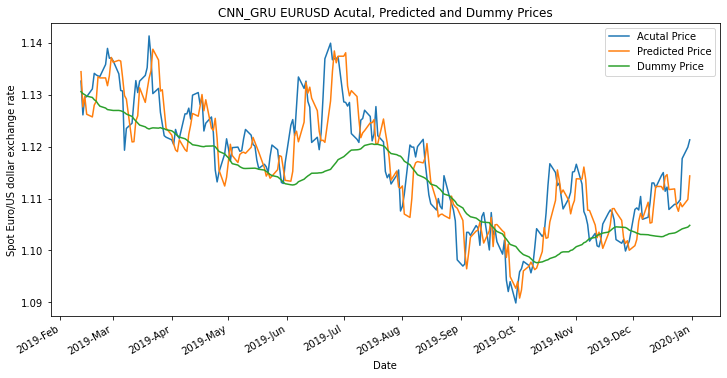

In [ ]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

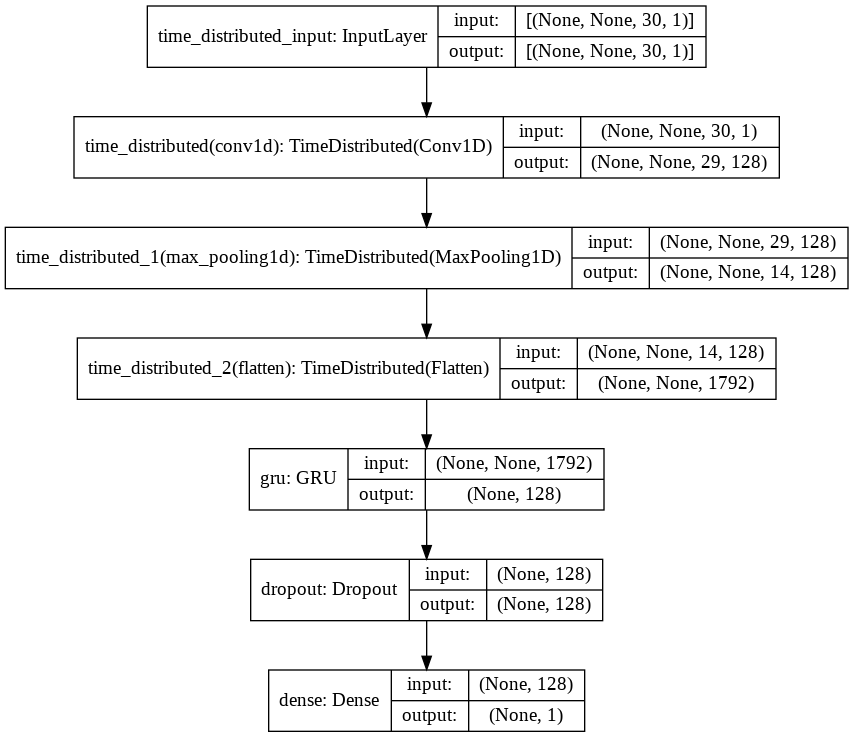

In [ ]:
plot_model(model, show_shapes=True, expand_nested=True)

In [ ]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.022523582956626452
RMSE:  0.15007858926784476
MAE:  0.12295908290636537
Dummy MSE:  0.0236885518332631
Dummy RMSE:  0.15391085677515767
Dummy MAE:  0.11970302826636056


In [ ]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_GRU_EURUSD/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_GRU_EURUSD/assets
